In [40]:
"""
Copyright (C) 2018 NVIDIA Corporation.    All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
from __future__ import division
import scipy.misc
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from numpy.lib.stride_tricks import as_strided
from PIL import Image
import matplotlib.pyplot as plt


#Class that defines operations for smoothing a stylized image.
class Smoother(object):
    def __init__(self, beta=0.9999):
        self.beta = beta

    #smooths stylized image using information from the content image.
    def smooth(self, initImg, contentImg):
        if type(contentImg) == str:
            content = scipy.misc.imread(contentImg, mode='RGB')
        else:
            content = contentImg.copy()

        if type(initImg) == str:
            B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64) / 255
        else:
            B = scipy.asarray(initImg).astype(np.float64) / 255
        h1,w1,k = B.shape
        #remove edge artifacts by pretending the image is 2 pixels smaller than it is per side
        h = h1 - 4
        w = w1 - 4
        B = B[int((h1-h)/2):int((h1-h)/2+h),int((w1-w)/2):int((w1-w)/2+w),:]
        content = scipy.misc.imresize(content,(h,w))
        #replace the removed edges with padding
        B = self.__replication_padding(B,2)
        content = self.__replication_padding(content,2)
        content = content.astype(np.float64)/255
        
        #Flatten the image
        B = np.reshape(B,(h1*w1,k))
        #Compute laplacian of the content image
        W = self.__compute_laplacian(content)
        W = W.tocsc() #make the laplacian sparse
        dd = W.sum(0) #Sum along the first axis of W
        dd = np.sqrt(np.power(dd,-1)) #Take dd to the -1/2 power
        dd = dd.A.squeeze() #remove the extra dimension at the end of dd
        D = scipy.sparse.csc_matrix((dd, (np.arange(0,w1*h1), np.arange(0,w1*h1)))) #blow up dd to become the diagonal of D
        S = D.dot(W).dot(D) #S = D dot W dot D
        A = scipy.sparse.identity(w1*h1) - self.beta*S #A = I - beta*S
        A = A.tocsc() #Make A sparse
        solver = scipy.sparse.linalg.factorized(A) # solves decomposition of A - will have 3 outputs
        V = np.zeros((h1*w1,k)) #V is the flattened shape of the output image
        V[:,0] = solver(B[:,0]) #Add each color channel back to V
        V[:,1] = solver(B[:,1])
        V[:,2] = solver(B[:,2])
        V = V*(1-self.beta)
        V = V.reshape(h1,w1,k) #Reshape V into the output image size
        V = V[2:2+h,2:2+w,:] #Remove the reflective padding so the image is the proper size
        
        img = Image.fromarray(np.uint8(np.clip(V * 255., 0, 255.))) #Clip images into RGB range
        return img

    # Returns sparse matting laplacian
    # The implementation of the function is heavily borrowed from
    # https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
    # We thank Marco Forte for sharing his code.
    def __compute_laplacian(self, img, eps=10**(-7), win_rad=1):
            win_size = (win_rad*2+1)**2 #compute the size of the window used - defaults to 3x3 window
            h, w, d = img.shape #extract shape from the image
            c_h, c_w = h - 2*win_rad, w - 2*win_rad #remove edges that would form fractional windows
            win_diam = win_rad*2+1
            indsM = np.arange(h*w).reshape((h, w)) #Indices in the range 0:h*w in the shape h by w
            ravelImg = img.reshape(h*w, d) #flatten the image pixels into color channels
            win_inds = self.__rolling_block(indsM, block=(win_diam, win_diam)) #change the indices into window indices
            win_inds = win_inds.reshape(c_h, c_w, win_size)
            winI = ravelImg[win_inds] #break the image up into windows
            win_mu = np.mean(winI, axis=2, keepdims=True) #Take the mean of each window
            win_var = np.einsum('...ji,...jk ->...ik', winI, winI)/win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu) #Take the variance of each window
            inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3)) #Fancy numpy to normalize the diagonal by the window size and add the inverse of the window variance elsewhere
            X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv) 
            vals = (1/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu)) #the values of the laplacian that will be added to the final array
            nz_indsCol = np.tile(win_inds, win_size).ravel() #col locations to add values at
            nz_indsRow = np.repeat(win_inds, win_size).ravel() #row locations to add values at
            nz_indsVal = vals.ravel() #values to add to the final array
            L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w)) #add the values into the n by n array at the proper indices
            return L

    #Adds padding of the specified amount to the edge of a given image by replication.
    def __replication_padding(self, arr,pad):
            h,w,c = arr.shape
            ans = np.zeros((h+pad*2,w+pad*2,c))
            for i in range(c):
                    ans[:,:,i] = np.pad(arr[:,:,i],pad_width=(pad,pad),mode='edge')
            return ans

    #Strides an input array in 2 dimensions into blocks of a given size.
    def __rolling_block(self, A, block=(3, 3)):
        shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
        strides = (A.strides[0], A.strides[1]) + A.strides
        return as_strided(A, shape=shape, strides=strides)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Smoothing image...
Content image:


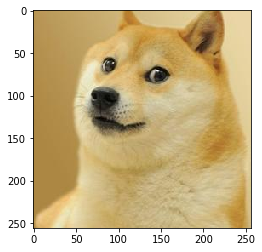

Styled image:


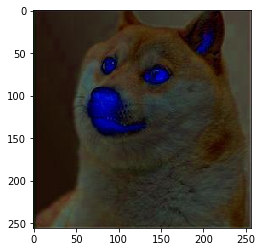

Smoothed image:


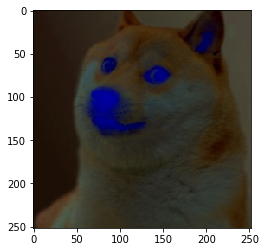

In [41]:
def smooth_image(styled_image,content_image):
    print("Smoothing image...")
    s = Smoother()
    smoothed_image = s.smooth(styled_image,content_image)
    print('Content image:')
    plt.imshow(content_image)
    plt.show()
    print('Styled image:')
    plt.imshow(styled_image)
    plt.show()
    print('Smoothed image:')
    plt.imshow(smoothed_image)
    plt.show()



styled_image = scipy.misc.imread('styled.jpg', mode='RGB')
content_image = scipy.misc.imread('doge-256.jpg', mode='RGB')

smooth_image(styled_image,content_image)